## Goals

Prepare for Neural Nets from scratch by estimating a generalized linear model via gradient descent (from scracth). 

We'll (briefly) cover 
* Working with matrices and n dimensional arrays in numpy.
* Solving the least squares problem directly (via normal equations) and indirectly (via gradient descent)
* Optimization, convexity and gradient descent.
* Estimate linear regression via gradient descent.
* Estimate logistic regression via gradient descent
* Estimating logistic regression via stochastic gradient descent (maybe)
* We'll wrap by estimating the logistic regression via Statsmodels, Scikit Learn, and TensorFlow!

## Prerequisites

Knowledge of the following is ideal.

* Matrix algebra
* Multivariate calculus

But you could get through this notebook with minimum matrix algebra alone.  In fact, as long as you understand how a matrix is used to store data, and you know how to do arithmetic on matrices (add, multiplication, and scalar multiplication) you will be find.  

## Working with matrices in numpy

The classes that represent matrices, and basic operations such as matrix multiplications and transpose are a part of numpy. 

`numpy.matrix` is matrix class that has a more convenient interface than `numpy.ndarray` for matrix operations. This class has matrix multiplication as default for the * operator, and contains `I` and `T` members that serve as shortcuts for inverse and transpose.  

Despite its convenience, the use of the `numpy.matrix` class is discouraged, since it adds nothing that cannot be accomplished with 2D `numpy.ndarray` objects, and may lead to a confusion of which class is being used.  With that being said, we will use the `numpy.matrix` class for this notebook.  Feel free to convert this notebook to ndarrays.  

## scipy.linalg vs numpy.linalg

`scipy.linalg` contains all the functions in `numpy.linalg`. plus some other more advanced ones not contained in `numpy.linalg`

Another advantage of using `scipy.linalg` over `numpy.linalg` is that it is always compiled with BLAS/LAPACK support, while for numpy this is optional. Therefore, the scipy version might be faster depending on how numpy was installed.

Therefore, unless you don’t want to add scipy as a dependency to your `numpy` program, use `scipy.linalg` instead of `numpy.linalg`.  That being said, we will use `numpy.linalg` for this notebook

## Matrix Operations

Below we'll demonstrate how to do some important operations necessary for regression from scracth, and we'll only highlight operations on matrices vs ndarrays when worth noting.

## Creating a matrix

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from scipy.linalg import expm
from pandasql import sqldf
import matplotlib.pyplot as plt
from sklearn import datasets

pysqldf = lambda q: sqldf(q, globals())

import seaborn as sns
%matplotlib inline
x = np.matrix([[2,7,6],[9,5,1],[4,3,8]])
print(type(x))
print(x)
# or
x_ndarray = np.array([[2,7,6],[9,5,1],[4,3,8]])
print("\n{}".format(type(x_ndarray)))
print(x_ndarray)

<class 'numpy.matrixlib.defmatrix.matrix'>
[[2 7 6]
 [9 5 1]
 [4 3 8]]

<class 'numpy.ndarray'>
[[2 7 6]
 [9 5 1]
 [4 3 8]]


The magice square above (call it $X$) is composed of 3 rows and 3 columns.  We will index elements by the row and column in which they appear.  For example, the element $X_{1,2}$ is 7 and $X_{3,3} = 8$.  

Generally, we will have a matrix $X$ of dimension $m \times n$, that is, $m$ rows and $n$ columns and we'll write $X \in \mathbb{R}^{m,n}$.  We'll use the following notations to refer to entire columns and / or rows very succinctly.  $(:,j)$ or $(i,:)$ which means all elements in the $j^{th}$ column and all elements in the $i^{th}$ row, repsectively.

### Transpose of a Matrix

Very fundamental operation is transposition - this is switching the row index with the column index for each element.  

In [2]:
print("X")
print(x)
print("\nX'")
print(x.T)

X
[[2 7 6]
 [9 5 1]
 [4 3 8]]

X'
[[2 9 4]
 [7 5 3]
 [6 1 8]]


### Slicing a matrix

Very often we'll be interested in a particular row or column or sub-matrix of a matrix.

In [3]:
# slicing
# first row
print("slicing a matrix\n")
print(x[0,:])
print("\nshape of x[0,:] is {}".format( x[0,:].shape))
print("\nvs slicing an ndarray\n")
print(x_ndarray[0,:])
print("\nshape of x_ndarray[0:] is {}".format(x_ndarray[0,:].shape))

slicing a matrix

[[2 7 6]]

shape of x[0,:] is (1, 3)

vs slicing an ndarray

[2 7 6]

shape of x_ndarray[0:] is (3,)


In [4]:
# slicing
# first column
print("slicing a matrix\n")
print(x[:,0])
print("\nshape of x[:,0] is {}".format( x[0,:].shape))
print("\nvs slicing an ndarray\n")
print(x_ndarray[:,0])
print("\nshape of x_ndarray[:,0] is {}".format(x_ndarray[0,:].shape))

slicing a matrix

[[2]
 [9]
 [4]]

shape of x[:,0] is (1, 3)

vs slicing an ndarray

[2 9 4]

shape of x_ndarray[:,0] is (3,)


In [5]:
# slicing 
# top 2x2 matrix
print(x[0:2,0:2])


[[2 7]
 [9 5]]


### Vectors

A vector is an array of numbers.  YOu could think of each row or each column of a matrix as a vector.  If $x$ is a vector of length $N$ we write $x \in \mathbb{R}^N$.

### Dot Product

Given two vectors $x,y$ in $\mathbb{R}^n$, the dot product (or inner product) of $x$ and $y$, written $x\cdot y$ or sometimes $\left<x,y\right>$ is defined as 
$$\left<x,y\right> = \sum_{i=1}^n x_i y_i$$

For $x = y$, the square root of the dot product is called the $L_2$ norm or Euclidean norm and may be written $\|x\|_2$.    
If $x$ sums to zero, then $\|x\|_2^2 \propto Var(x)$

## Inner product and correlation coefficient.  

For any two vectors $x,y \in \mathbb{R}^N$, we have 

$$\cos(\theta) = \frac{x\cdot y}{\|x\|\|y\|}$$

where $\theta$ is the angle between $x$ and $y$.  If $x$ and $y$ both sum to 0 then $\cos(\theta)$ is the correlation between $x$ and $y$.  Why?  because $\left<x,y\right>$ is the sample covariance and $\|x\|, \|y\|$ are the sample standard deviations of $x$ and $y$ respectively.


### Matrix Multiplication 

If $A$ is $m \times n$ and $B$ is $n \times p$, then the product $C = AB$ is $m \times p$ and the 

$i,j$ element of $C$ is defined as 

$$C_{i,j} = A_{i,:} \cdot B_{:,j} = \sum_{k=1}^n A_{i,k}B_{k,j}$$

Or we could say that the $i,j$ element of $C$ is the dot product of the $i^{th}$ row of $A$ and the $j^{th}$ column of $B$. 



In [6]:
# dot products
z = np.array([1,2,3])
z.dot(z)

14

In [7]:
# matrix multiply
print(x * x)

# same as 
y = np.zeros([3,3])
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        y[i][j] = x[i,:].dot(x[:,j])
print()
print(y)

[[91 67 67]
 [67 91 67]
 [67 67 91]]

[[ 91.  67.  67.]
 [ 67.  91.  67.]
 [ 67.  67.  91.]]


### Hadamard Product

For two matrices $A$ and $B$ the Hadamard Product, written $A \odot B$, is element wise multiplicate, thus $\dim(A)$ must equal $\dim(B)$

In [8]:
# hadamard product -- element-wise multiplication
print(np.multiply(x,x))

[[ 4 49 36]
 [81 25  1]
 [16  9 64]]


### Identify Matrices and Matrix Inversion


In [9]:
# identity matrix
I = np.eye(3)
print(x * I)
print()
print(I * x)

[[ 2.  7.  6.]
 [ 9.  5.  1.]
 [ 4.  3.  8.]]

[[ 2.  7.  6.]
 [ 9.  5.  1.]
 [ 4.  3.  8.]]


In [10]:
# inverting a square matrix
print(np.linalg.inv(x))
print()
print( np.round(x*np.linalg.inv(x),2))

[[-0.10277778  0.10555556  0.06388889]
 [ 0.18888889  0.02222222 -0.14444444]
 [-0.01944444 -0.06111111  0.14722222]]

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]


In [11]:
# "inverting" a non-square matrix
x1 = np.concatenate( (x, np.matrix([10,12,11])), axis=0)
pinv = np.linalg.pinv(x1)
print("x1")
print(x1)
print("\npseudo inverse of x1")
print(pinv)
print("\npinv*x1")
print(np.round(pinv*x1,1))

x1
[[ 2  7  6]
 [ 9  5  1]
 [ 4  3  8]
 [10 12 11]]

pseudo inverse of x1
[[-0.10158658  0.10631095  0.06449901 -0.00116214]
 [ 0.13958365 -0.00904452 -0.16969835  0.04810267]
 [-0.02602193 -0.0652822   0.14385327  0.00641706]]

pinv*x1
[[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0. -0.  1.]]


### Other useful operations

In [13]:
# multiplication by scalar
p = 1/15 * x
p

matrix([[ 0.13333333,  0.46666667,  0.4       ],
        [ 0.6       ,  0.33333333,  0.06666667],
        [ 0.26666667,  0.2       ,  0.53333333]])

In [14]:
# sum columns
print( p.sum(axis=0))
print()
# sum rows 
print( p.sum(axis=1))

[[ 1.  1.  1.]]

[[ 1.]
 [ 1.]
 [ 1.]]


In [15]:
# mean and standard deviation of columns
print( x.mean(axis=0), x.std(axis=0))
# mean of rows - just set axis=1


[[ 5.  5.  5.]] [[ 2.94392029  1.63299316  2.94392029]]


In [16]:
## numpy funtions act element-wise on matrices and arrays
np.exp(p)

matrix([[ 1.14263081,  1.59466976,  1.4918247 ],
        [ 1.8221188 ,  1.39561243,  1.06893911],
        [ 1.30560517,  1.22140276,  1.70460487]])

In [17]:
## for functions of matrices look into scipy.linalg, e.g., exponetial of matrix
print(expm(p))

[[ 1.40505877  0.69054062  0.62268243]
 [ 0.826257    1.60863334  0.28339149]
 [ 0.48696606  0.41910787  1.81220791]]


In [18]:
# Taylor Approx of exp(p)
def fact(n):
    if n == 1:
        return n
    else:
        return n*fact(n-1)

#np.eye(3) + p + 1/2*p*p + 1/6*p*p*p + 1/24*p*p*p*p + 1/120*p*p*p*p*p
e = np.eye(3)
for i in range(1,10):
    e += 1/fact(i)*np.linalg.matrix_power(p,i)
print(e)

[[ 1.40505867  0.69054052  0.62268233]
 [ 0.8262569   1.60863324  0.28339139]
 [ 0.48696595  0.41910777  1.81220781]]


In [19]:
# matrix of ones
bias = np.matrix(np.ones([3,1]))
# joining the matrix of ones with our matrix x1 from above
# very common for regression problems
x2 = np.concatenate( [bias, x],axis=1)
print(x2)
print()
# to append the bias as a row, we'll do the following
x3 = np.concatenate( [x2, np.ones([1,4])],axis=0)
print(x3)

[[ 1.  2.  7.  6.]
 [ 1.  9.  5.  1.]
 [ 1.  4.  3.  8.]]

[[ 1.  2.  7.  6.]
 [ 1.  9.  5.  1.]
 [ 1.  4.  3.  8.]
 [ 1.  1.  1.  1.]]


A very conventient method for adding in bias to a regression model is through statsmodels via `statsmodels.api.add_constant`.  This will check the rank of your matrix prior to adding a constant

In [20]:
import statsmodels.api as sma
sma.add_constant(x)

C:\Users\Whittakert\Anaconda3\envs\pgh_data_science\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


matrix([[ 1.,  2.,  7.,  6.],
        [ 1.,  9.,  5.,  1.],
        [ 1.,  4.,  3.,  8.]])

Demonstrate similar operations on nd arrays


In [21]:
x = np.array([[2,7,6],[9,5,1],[4,3,8]])

print("Hadamard product X \odot X")
print(x*x) # if x were a matrix, this would be matrix mulitply
print("matrix multiply X'X using np.dot")
print( np.dot(x.T,x))
print("matrix multiply X'X using np.matmul")
print( np.matmul(x.T, x))
print("matrix multiply X'X using @")
print( x.T @ x)

Hadamard product X \odot X
[[ 4 49 36]
 [81 25  1]
 [16  9 64]]
matrix multiply X'X using np.dot
[[101  71  53]
 [ 71  83  71]
 [ 53  71 101]]
matrix multiply X'X using np.matmul
[[101  71  53]
 [ 71  83  71]
 [ 53  71 101]]
matrix multiply X'X using @
[[101  71  53]
 [ 71  83  71]
 [ 53  71 101]]


In [22]:
# mean of rows
x2.mean(axis=1)

matrix([[ 4.],
        [ 4.],
        [ 4.]])

In [23]:
# mean of each column
x2.mean(axis=0)

matrix([[ 1.,  5.,  5.,  5.]])

In [24]:
np.multiply(x2.mean(axis=0),np.ones([3,4]))

matrix([[ 1.,  5.,  5.,  5.],
        [ 1.,  5.,  5.,  5.],
        [ 1.,  5.,  5.,  5.]])

In [25]:
## calc covariance and correlation matrix

z = np.matrix(x2 - np.multiply(x2.mean(axis=0),np.ones([3,4])))
sig = np.sqrt(np.diag(np.diag(z.T*z)))


print("covariance matrix")
print(z.T*z / 2)
print()
print("correlation matrix")
print(np.linalg.pinv(sig)*(z.T*z)*np.linalg.pinv(sig))
## since the generalized inverse was used the first row and column are 0 instead of nan

covariance matrix
[[  0.   0.   0.   0.]
 [  0.  13.  -2. -11.]
 [  0.  -2.   4.  -2.]
 [  0. -11.  -2.  13.]]

correlation matrix
[[ 0.          0.          0.          0.        ]
 [ 0.          1.         -0.2773501  -0.84615385]
 [ 0.         -0.2773501   1.         -0.2773501 ]
 [ 0.         -0.84615385 -0.2773501   1.        ]]


## Generating Data

In [26]:
import seaborn as sns

In [27]:
## useful function from statsmodels
from statsmodels.api import add_constant
## add_constant will check the rank of your matrix prior to adding a column on 1s.

n=500
np.random.seed(123)
X = np.random.randn(n,2)
c = np.matrix(np.ones([n,1]))
w = np.random.randn(2,1) * 2
bias = np.random.randn(1)[0] 

# for linear regression 
y = np.matmul(X,w) + bias + np.random.randn(n,1)*2


# for logistic regression
g = (X*X).sum(axis=1)
noise = np.random.lognormal(-1,1,n)
g = 1*( (g + noise ) > 2)
# y = y + noise
g = np.matrix(g).T



In [28]:
column_names = ['y', "g"]
column_names.extend( ['x{}'.format(i) for i in range(X.shape[1])])
data = DataFrame(np.concatenate( [y.reshape(n,1),g.reshape(n,1), X], axis=1), 
                 columns = column_names )
data.describe()

,y,g,x0,x1
count,500.000000,500.000000,500.000000,500.000000
mean,0.867117,0.526000,-0.042167,-0.036961
std,2.560496,0.499824,1.011905,0.991565
min,-5.227929,0.000000,-3.167055,-3.231055
25%,-1.042395,0.000000,-0.692185,-0.682595
50%,0.771242,1.000000,-0.043672,-0.040681
75%,2.614019,1.000000,0.683227,0.642703
max,8.679778,1.000000,2.766603,3.571579


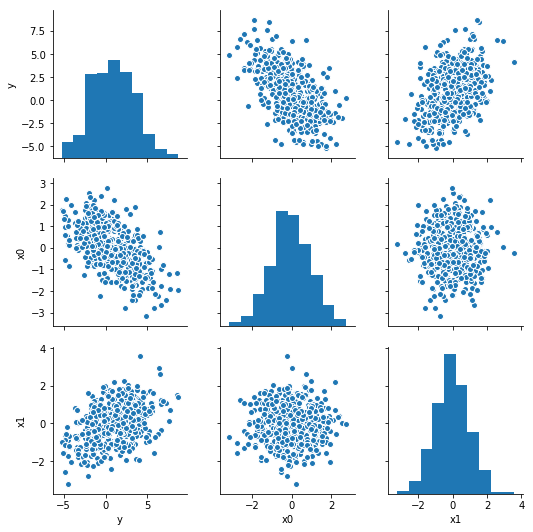

In [29]:
sns.pairplot(data.drop(["g"], axis=1))

In [30]:
# add bias into X
X = np.concatenate( (c,X), axis=1)

## Fitting a Linear Regression

Fitting a linear regression is a fairly simply procedure, but can be prove difficult if there are a significant number of observations, or if there are more features than observations.  

If we suppose that our target variable $y$ can be written as a linear combination of features $X_1, X_2, \ldots, X_n$, i.e., 

$$y = a + b_1X_1 + b_2X_2 + \cdots + b_nX_n + \epsilon$$

We can write the succinctly in matrix form as 

$$y = X\beta + \epsilon$$

Our objective now is to attempt to provide the single "best" estimate of the weights.  This is known as point estimation.  We easily justified method to select "best" estimates is be minimizing the average squared distance between the linear projection of our feature matrix and the target ($\|y - X\beta\|_2$).  

$$C(\beta) = \frac{1}{N}\sum_{i=1}^N (y_i - X_i\beta)^2$$

Here $i$ is used to index the rows of the matrix.  The object above is referred to as the mean square error.  

We may write it in matrix form as 

$$ C(\beta) = \frac{1}{N} (y - X\beta)^T(y - X\beta)$$

Therefore, we can do some calculus to find the "best" estimate of the weights.  

$$ \frac{\partial}{\partial \beta} C(\beta) = -\frac{1}{N}X^T(y - X\beta)$$

Setting this equal to 0 and solving for $\beta$ yields the normal equations.  

$$ \beta^* = (X^TX)^{-1}X^Ty $$

Notice how we wrote $\beta^*$ instead of $\beta$.  From the frequentist perspective $\beta$ is a fixed value, and what we wrote above is a point estimate of $\beta$, which is a function of random variables, $\beta$ itself is a random variable, so we will write $\beta^*$ instead.  

FYI, the matrix of all partial derivatives is referred to as the Hessian. 
$$\frac{\partial^2 C}{\partial \beta_i\partial\beta_j} = \frac{1}{N}X^TX$$
Note that if $X$ is centered the Hessian is the covariance matrix!

In [31]:
## solution to the least squares problem
print(np.linalg.inv(X.T*X)*X.T*y)

[[ 0.84593582]
 [-1.43518365]
 [ 1.06426769]]


In [32]:
## solution to least squares problem via pseudo inverse
## this would probably be preferred froma  stability perspective
## but not from a speed perspective (depends on implementation)
print(np.linalg.pinv(X)*y)

[[ 0.84593582]
 [-1.43518365]
 [ 1.06426769]]


#### More variables than observations or highly correlated features? 

We typically assume that there are more rows than columns or that correlation among columns is small (in the absolute sense), but there will be instances where there are (many) more columns than rows, or variables that have correlation close to 1.  When this happens, the covariance matrix is singular or nearly singular.    

One popular method to handle this is via ridge regression.  This method shrinks the coefficients of the regression towards zero and in the event of highly correlation features, the regression coefficients "borrow" from one another.    Starting with 

$$C(\beta) = (y - x\beta)^T(y-x\beta)$$

We add some penality, which is a function of $\beta$ as well.  The penalty will be used to keep the model from saturating.  A penalty which lends itself well to this problem is the $L^2$ norm.   

$$C^*(\beta) = \frac{1}{2} C(\beta) + \frac{\lambda}{2} \|\beta\|$$

There is a closed form solution to this problem.  

$$\frac{\partial C^*}{\partial \beta} = -x^T(y-x\beta) + \lambda \beta$$

Setting this derivative equal to 0, we get 

$$0 = -x^Ty + x^Tx\beta + \lambda \beta = -x^Ty + (x^Tx + \lambda I)\beta$$

Thus 

$$\hat{\beta} = (x^Tx + \lambda I)^{-1} x^Ty$$

Basically, we add a small amount to the diagonal of covariance matrix of $x$ to insure invertibility so that the solution exists.  

Above, we just introduced the notion of regularization.  We added a penalty to the optimization problem, and now the solution offers a trade off between fit and its norm.  This can help with overfitting and stability of the model with highly correlated predictors and when the number of features is large.  This regularization is easily implemented when learning neural networks, and that is why we introduce it here.  

## Optimization

### Global vs Local Optimum

If $f$ is a function and $x$ a point in the domain of $f$ such that $f(x) \le f(y)$ for all other $y$ in the domain of $f$.  Then we say that $x$ is a global optimum.  

On the other hand, given an $x$ in the domain of $f$ and if there exists open interval containing $x$ such that $f(x) \le f(y)$ for all $y$ in the open interval then we say that $x$ is a local optimum.  

In the least square optimization problem we found the global solution.  We are certain that it is global because the least square problem is a convex optimization problem.  

### Convexity

Given a function $f$, and points $a$ and $b$ in domain $f$, we say $f$ is convex if for points $x,y,z$ in domain of $f$ such that $a < x <  y <  z< b$ we have the following inequality

$$\frac{ f(y) - f(x) }{y - x} \le \frac{ f(z) - f(y)}{z - y}$$

Convex function have several nice properties
1.  If $f$ is convex on its domain then $f$ is continuous on its domain.
2.  If $f$ is convex and $x^*$ is a local optimum then $x^*$ is global optimum.  

To see number 2, suppose that $x$ is a local optimum, and that $x^*$ is such that $f(x^*) < f(x)$.  WLOG, let $x < x^*$.  We can easily find $a,c,b$ such that $a < x < c < x^* < b$ and f(x) \le f(b) and $f(x^*) < f(b)$. 

$$ \frac{f(c) - f(x)}{c - x} \le \frac{f(x^*) - f(c)}{x^* - c}$$

the left hand side is greater than or equal to zero, while the right is strictly less than zero, but this contradicts our definition of convexity.  

For the least squares problem, the cost function is convex, this implies that any local minimum we find is a global minimum.   
There is no guarantee a convex function has a local optimum, i.e., $e^x$. 

## Gradient Descent

Linear regression is fairly simple to solve (as shown above).  The least squares cost function lends itself to a nice closed form solution, but sometimes (with other cost functions) that is not always the case and we  we must settle for a numerical (approximate) solutions.  Additionally, the least squares solution is very easy to calculate when the number of features and observations are reasonalbe, but sometimes  but that is not always the case.  Suppose that our feature matrix $X$ is $m \times n$, i.e, $m$ rows and $n$ features.  Solving the linear regression would require several steps of varying [complexity](https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations#Matrix_algebra)
1.  $X^TX$ which has $O(n^2m)$ complexity
2.  Inverting $X^TX$ has $O(n^{3})$ Complexity
3.  $X^Ty$ has complexity $O(mn)$.

Gradient descent is a first order optimization method, that is, it only uses first derivatives to solve the optimization problem (i.e., find a local extremum).  

This method is so great because 

* you don't need to work about the hessian of the objective function.  Consider Newton Rhapson method which requires calculating the hessian and then inverting it.  If there are $p$ parameters to solve for, the Hessian will be $p \times p$.  This can be very expensive for large problems!! 
* it is very easy to implement
* it is embarrasingly parrallelizable
* its extension, Stochastic Gradient Descent is very popular in training neural nets.  


### Intuition behind gradient descent

For intuitions sake, lets consider $f: \mathbb{R} \to \mathbb{R}$ which is at least differentiable on its domain. We know that for any $x$ in the domain of $f$, we have 

$$f\big(x - \epsilon \;\text{sign}(f'(x)\big) \le f(x)$$ 

for small enough $\epsilon$.  To see this, suppose that for some $x$ in domain of $f$, and $f'(x) > 0$, then $f$ is increasing at $x$, thus there exists $\epsilon > 0$ such that $f(x - \epsilon) < f(x)$.  On the other hand, if $f'(x) < 0$ then there exists $\epsilon > 0$ such that $f(x + \epsilon) < f(x)$.  Lastly if $f'(x) = 0$, then we are at a (local) optimum.  This means that we can reduce $f$ by moving $x$ by a small amount in the direction opposite the sign of its derivative.  Once $f'(x) = 0$, the derivative provides no information about which direction to move.  

### Extending to several dimensions

Moving to functions of several variables $f: \mathbb{R}^N \to \mathbb{R}$.  We will consider the gradient and the directional derivative.  The directional derivative of a function in the direction $(u_1,u_2)$ is the slope of the function $f$ in the direction $(u_1,u_2)$, usually with $u_1^2 + u_2^2 = 1$

The gradient is an N-tuple of partial derivatives of $f$, written $\nabla f$.  

We will also be interested in the directional derivative.  The directional derivative of $f$ in the direction of $u = (u_1, u_2)$ where $\|u\| = 1$ is 

$$\frac{\partial}{\partial \alpha} f(x_0 + \alpha u_1, y_0 + \alpha u_2)$$

If we write $g(\alpha) = f(x_0 + \alpha u_1, y_0 + \alpha u_2)$, and $x = x_0 + \alpha u_1, y = y_0 + \alpha u_2$

$$g'(\alpha) = \frac{\partial f}{\partial x}\frac{\partial x}{\partial \alpha}
+ \frac{\partial f}{\partial y}\frac{\partial y}{\partial \alpha} = f_x(x,y) u_1 + f_y(x,y) u_2$$

Lastly, 
$$g'(0) = f_x(x_0, y_0) u_1 + f_y(x_0, y_0) u_2 = \nabla f \cdot u,$$

To minimize $f$ we would liek to find the direction in which $f$ decreases fastest, queue the directional derivative, we will minimize 

$$\min_{u, \|u\|=1} \nabla f \cdot u$$

Multiply the top and bottom by $\|u\| \|\nabla f\|$ to get 

$$\min_{u, \|u\|=1}\|u\| \|\nabla f\| \cos(\theta)= \min_{u, \|u\|=1}\|\nabla f\| \cos(\theta)$$

where $\theta$ is the angle between $u$ and the gradient.  The direction is such that $u$ points in the direction opposite of the gradient ( cosine of this angle will be -1)

For the least squares problem described above, our gradient descent algorithm becomes
~~~
grad = -X'*(y - X*beta)
while norm(grad) > 1e-6
  grad = -X'*(y - X*beta)
  beta -= learning_rate * grad / n
~~~
We will set the learning rate to some small amount like 0.1.

## Linear Regression via Gradient Descent

In [33]:
## create the objective function 

class MSE(object):
    def valueAt( x, y, beta):
        yhat = x * b
        e = y - yhat
        return y.T*y / x.shape[0]
    def gradientAt(x, y, beta):
        yhat = x * beta
        e = y - yhat
        return -x.T*e / x.shape[0]
  
class L2(object):
    def valueAt(b):
        return 1/2*linalg.norm(b) 
    def gradientAt(b):
        return b
        
        
    
class GradientDescent(object):
    def __init__(self, cost_function=MSE, tolerance=1e-6, regularization=None):
        self.cost_function = cost_function
        self.tol = tolerance
        self.iter = 0
        self.beta = None
        self.regularization = regularization
        
    def optimize(self, X,y,learning_rate=0.1,init_params=None):
        if init_params is None:
            beta = np.matrix( np.zeros(X.shape[1])).T
        else:
            beta = init_params
        grad = self.cost_function.gradientAt(X,y,beta)
        if self.regularization is not None:
            pass
        prev_beta = beta
        beta = beta - learning_rate*grad
        ## several termination criteria to use
        ## abs change in beta is small
        ## abs change in beta / norm of beta 
        ## abs change in object is small
        ## here we use magitute of the gradient
        while np.linalg.norm(prev_beta - beta)/np.linalg.norm(beta) > self.tol:
            prev_beta = beta
            self.iter += 1
            grad = self.cost_function.gradientAt(X,y,beta)
            if self.regularization is not None:
                pass
            beta = beta - learning_rate*grad
        self.beta = beta
        return beta

In [34]:
## exercise - how to add regularization into the gradient descent??

## Fitting a Logistic Regression

Given a categorical variable $y$ with 2 classes (binary variable), $y$ can best be described as a Bernoulli random variable - which is a random variable that takes the value $A$ with probability $p$ and the value $B$ with probability $1 - p$.  

We are interested in modeling the posterior probabilities of the 2 classes via some linear function in $x$.  

$y$ can best be described as a Bernoulli random variable, that is a variable that can assume two values

The model takes the form

$$ \log \frac{ \mathbb{P}(y = 1 | X = x) }{ \mathbb{P}(y = 0 | X = x) } = x\beta $$

The function on left hand side is known as the logit function.  

It can be shown then that 
$$ \mathbb{P}(y = 1 | X = x) = \frac{\exp(x\beta)}{(1 + \exp(x\beta)}$$
The function on the right is the sigmoid function and is strictly between 0 and 1.  
and 
$$ \mathbb{P}(y = 0 | X = x) = 1 - \mathbb{P}(y = 1 | X = x)$$ 

We will use objective function 

$$-\sum_{i=1}^N \big(y_i\log(p_i) + (1 - y_i)\log(1 - p_i)\big)$$

Unfortunately, there is not closed form solution to this problem and must be solved numerically, but the good thing is that it is convex - so any local optimum is a global optimum.  

In [35]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

## creating this as object to expose value and gradient methods 
class BCE(object):
    
    def valueAt( x, y, beta):
        p = sigmoid(x*beta)
        ll = y.T*(np.log(p + 1e-3)) + (1 - y).T*( np.log(1 - p + 1e-3))
        return -ll / x.shape[0]
        
    def gradientAt( x, y, beta):
        p = sigmoid(x*beta)
        grad = x.T.dot(y - p) / x.shape[0]
        return -grad

In [36]:
# let's add in the square of each X
X = np.concatenate( (X, np.multiply(X[:,1:],X[:,1:])) ,axis=1)

In [37]:
logistic_regression = GradientDescent(BCE, tolerance=1e-7)
b = logistic_regression.optimize(X,g,learning_rate=1) ## show the perils of large learning rate
print("iterations: {}".format(logistic_regression.iter))
print(logistic_regression.beta.T)
BCE.valueAt(X,g,b)

iterations: 2810
[[-5.49708632  0.0088727   0.02967758  3.86156492  3.93428373]]


matrix([[ 0.1986892]])

In [38]:
data["phat"] = 1*(sigmoid(X.dot(logistic_regression.beta))>0.5)
data.head()

,y,g,x0,x1,phat
0,1.477465,1.0,-1.085631,0.997345,1
1,-0.465787,1.0,0.282978,-1.506295,1
2,-0.277612,1.0,-0.578600,1.651437,1
3,3.460264,1.0,-2.426679,-0.428913,1
4,-4.430196,1.0,1.265936,-0.866740,1


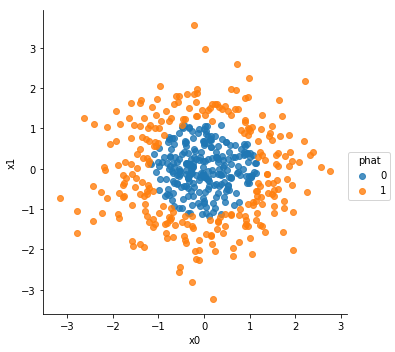

In [39]:
sns.lmplot('x0','x1',data,hue='phat',fit_reg=False)

In [40]:
pysqldf("select g, phat, sum(1) from data group by g, phat;")

,g,phat,sum(1)
0,0.0,0,220
1,0.0,1,17
2,1.0,0,22
3,1.0,1,241


In [41]:
## need precision and recall and accuracy, maybe f1

## stochastic gradient descent

Stochastic graident descent (SGD) is the defacto method for training neural networks.  It is also used to train large linear models on very large datasets.  

As we have seen with our linear and logistic regression examples above, the cost functions are additive, and the gradient descent algorithm can cost alot in terms of the computations involves.  

Stochastic gradient descent computes the gradient using as few a one example to as many as a few hundred.  This sample is referred to as a minibatch, and we will need to set the minibatch size as an algorithm.  The minibatch of sample is drawn uniformly from the training data.  This implies that a model may be trained on very few number of expamples relative to the entire dataset.  

This algorithm is very useful when data sets are huge, and cannot fit in main memory.  It also easily incorporates new data into the updates of a model.  

On each step of the algorithm, we sample a minibatch of examples from the training data.  The minibatch size typically ranges between 1 and a few hundred.  Small batches can offer regularizing effects, but will also require very small learning rates.  Depending on the way sampling of examples, 

~~~
learning_rate = e
beta = np.random.randn(n,1)
while stopping criterion not met do:
  sample a minibatch of m examples from the training set
  computer gradient estimate g <- 1/m grad( sample ) 
  update beta <- beta - learning_rate*g
~~~

#### AdaGrad (adaptive gradient) 

This algorithm inidividually adapts the learning rate of all model parameters.  

In [42]:
## sgd with adagrad
minibatch_size = 128
nobs, num_features = X.shape
num_outputs = 1
u = np.sqrt(6/(num_features + num_outputs)) ## Glorot and Bengio
beta = np.random.uniform(-u, u,num_features )
beta = np.matrix(beta).T
epochs = 1000
num_batches = 64
it = 0
############# specific to adagrad ##########
epsilon = 1.0  ## global learning rate
delta = 1e-7
r = np.matrix( np.zeros([X.shape[1],1]))
############################################

In [43]:
c = []
for i in range(epochs):
    index = np.arange(X.shape[0])
    np.random.shuffle(index)
    for i in np.arange( np.ceil(nobs/num_batches)):
        it += 1
#         batch = index[:num_batches] if len(index) > num_batches else index.copy()
#         index = np.delete(index, np.arange(num_batches)) if len(index) > num_batches else None
        batch = np.random.choice(nobs, minibatch_size, replace=False)
        grad = BCE.gradientAt(X[batch, :], g[batch], beta)
        r = r + np.multiply(grad, grad)
        update = np.multiply(epsilon / (delta + np.sqrt(r)) , grad)
        beta = beta - update
        c.append(BCE.valueAt(X,y,beta)[0,0])
        if it < 10:
            print("cost function at current beta: {}".format(BCE.valueAt(X,y,beta)))
print()
print(BCE.valueAt(X,y,beta), np.linalg.norm(BCE.gradientAt(X,y,beta)))
print()
print(beta.T)
print("iterations {}".format(it))

cost function at current beta: [[ 1.20780169]]
cost function at current beta: [[ 1.50919928]]
cost function at current beta: [[ 0.84468253]]
cost function at current beta: [[ 0.55701768]]
cost function at current beta: [[ 0.62173676]]
cost function at current beta: [[ 0.72617202]]
cost function at current beta: [[ 0.4874312]]
cost function at current beta: [[ 0.64557414]]
cost function at current beta: [[ 0.88167631]]

[[ 1.48372259]] 1.89031204371

[[-5.49593151  0.02199514  0.08461518  3.85593424  3.95159709]]
iterations 8000


## Statsmodels

In [44]:
import statsmodels.api as sma
import statsmodels as sm
fit = sma.GLM(endog = g, exog=X, family = sma.families.Binomial()).fit()
print(fit.summary())
sm_parms = fit.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      495
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 14 Dec 2017   Deviance:                       200.53
Time:                        21:01:42   Pearson chi2:                     431.
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.4973      0.559     -9.842      0.000      -6.592      -4.403
x1             0.0089      0.219      0.041      0.9

C:\Users\Whittakert\Anaconda3\envs\pgh_data_science\lib\site-packages\statsmodels\genmod\families\family.py:1003: RuntimeWarning: divide by zero encountered in true_divide
  return scale * np.sum((endog * np.log(mu/(1 - mu) + 1e-200) +
C:\Users\Whittakert\Anaconda3\envs\pgh_data_science\lib\site-packages\statsmodels\genmod\families\family.py:1004: RuntimeWarning: divide by zero encountered in log
  np.log(1 - mu)) * freq_weights)
C:\Users\Whittakert\Anaconda3\envs\pgh_data_science\lib\site-packages\statsmodels\genmod\families\family.py:1004: RuntimeWarning: invalid value encountered in add
  np.log(1 - mu)) * freq_weights)


## Scikit learn

In [45]:
from sklearn.linear_model import SGDClassifier as SGD

In [48]:
sgd = SGD(loss='log', fit_intercept=False, max_iter=1000)

In [49]:
sgd_fit = sgd.fit(X, np.array(g.T)[0])

In [50]:
sklearn_parms = sgd_fit.coef_
print(sklearn_parms)

[[-5.34196579  0.00714655  0.03303664  3.76442085  3.82121325]]


## TensorFlow

Next, we'll estimate the same logistic regression via TensorFlow

In [51]:
import tensorflow as tf

In [52]:
nobs, n_features = X.shape

# create the computational graph

learning_rate = tf.placeholder("float") # learning rate
xt = tf.placeholder("float", shape = [None, n_features]) # x as a tensor
yt = tf.placeholder("float", shape = [None, 1]) # y as a tensor
weights = tf.Variable(tf.random_normal([n_features,1]), name="weights" )
logits = tf.matmul(xt, weights) ## notice we don't apply the sigmoid function at all
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = yt))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# run the graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100):
        sess.run(optimizer, feed_dict = {yt: g, xt: X, learning_rate: 10 })
    tf_parms = sess.run(weights)
    print(tf_parms.T)
    

[[-5.45570564  0.00886405  0.02848718  3.83229542  3.90475273]]


In [53]:

parms = DataFrame([np.array(b).ravel(), np.array(beta).ravel(), tf_parms.ravel(), sklearn_parms.ravel(), sm_parms]).T
parms.columns = ["gd from scracth", "sgd from scratch", "tensorflow", "sklearn", "statsmodels"]
parms

,gd from scracth,sgd from scratch,tensorflow,sklearn,statsmodels
0,-5.497086,-5.495932,-5.455706,-5.341966,-5.497253
1,0.008873,0.021995,0.008864,0.007147,0.008873
2,0.029678,0.084615,0.028487,0.033037,0.029682
3,3.861565,3.855934,3.832295,3.764421,3.861683
4,3.934284,3.951597,3.904753,3.821213,3.934403
